# CESM2-LE Initial Condition Memory:  AMOC
 - Use Intake to access CESM2LE data on glade
 - Compute annual AMOC(1000m) from POP monthly output for all members from 1850-2100
 - Plot Hovmuller of micro-to-total variance vs. time
 - Request at least 50GB on Casper login to run this notebook

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [34]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [3]:
cluster

In [4]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc'
if (exists(pp_datafile)):
        print(pp_datafile+' already exists.\n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc already exists.




If CESM2LE post-processed zonal mean SST file already exists, you don't need to do Section 1 (~30 minutes). Go to [Section 2](#section2). 

# Section 1

## Data Intake

In [5]:
# Point to the catalog file
#catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
catalog_file = '/glade/work/mgrover/intake-esm-catalogs/glade-cesm2-le.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
# Find POP TEMP and SALT assets
oceandata = col.search(component='ocn', variable=['MOC'], experiment=['historical','ssp370'])

In [9]:
## Use preprocessor to return annual mean MOC
def preproc(ds):
    ds = calc.center_time(ds)
    ds_ann = ds.groupby('time.year').mean().rename({'year':'time'})
    ds_ann = ds_ann.sum('moc_comp')
    ds_ann.MOC.attrs = ds.MOC.attrs
    return ds_ann

In [10]:
%%time
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Create a dataset dictionary from the subsampled catalog
cbc_args = {'data_vars':'minimal'}
dsets = oceandata.to_dataset_dict(
    #xarray_combine_by_coords_kwargs=cbc_args,
    preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min, sys: 2.38 s, total: 1min 3s
Wall time: 1min 40s


In [11]:
dsets.keys()

dict_keys(['ocn.historical.pop.h.smbb.MOC', 'ocn.ssp370.pop.h.cmip6.MOC', 'ocn.ssp370.pop.h.smbb.MOC', 'ocn.historical.pop.h.cmip6.MOC'])

In [12]:
dsets['ocn.ssp370.pop.h.smbb.MOC'].MOC

,Array,Chunk
Bytes,790.47 MiB,188.24 kiB
Shape,"(50, 86, 2, 61, 395)","(1, 1, 2, 61, 395)"
Count,52500 Tasks,4300 Chunks
Type,float32,numpy.ndarray


## Data Processing

No further processing required, just load data arrays:

In [13]:
%%time
cmip6hist = dsets['ocn.historical.pop.h.cmip6.MOC'].MOC.load()
smbbhist = dsets['ocn.historical.pop.h.smbb.MOC'].MOC.load()
cmip6ssp = dsets['ocn.ssp370.pop.h.cmip6.MOC'].MOC.load()
smbbssp = dsets['ocn.ssp370.pop.h.smbb.MOC'].MOC.load()

CPU times: user 1min 31s, sys: 8.06 s, total: 1min 39s
Wall time: 1min 46s


In [14]:
## Create final Dataset:
work1 = xr.concat([cmip6hist,cmip6ssp],dim='time')
work2 = xr.concat([smbbhist,smbbssp],dim='time')
cesm2le = xr.concat([work1,work2],dim='member_id')
memid = cesm2le.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':cesm2le.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':cesm2le.member_id})

ds = cesm2le.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

In [15]:
pp_datafile

'/glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc'

In [16]:
## Save to netcdf:
ds.to_netcdf(pp_datafile)

<a id='section2'></a>

# Section 2

If you skipped Section 1, read in ds for analysis and plotting:

In [5]:
print('opening '+pp_datafile)
ds = xr.open_dataset(pp_datafile)

opening /glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc


In [6]:
ds

<xarray.Dataset>
Dimensions:       (time: 251, lat_aux_grid: 395, moc_z: 61, member_id: 100, transport_reg: 2)
Coordinates:
  * time          (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z         (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
  * member_id     (member_id) object 'r10i1181p1f1' ... 'r9i1171p1f2'
Dimensions without coordinates: transport_reg
Data variables:
    MOC           (member_id, time, transport_reg, moc_z, lat_aux_grid) float32 ...
    inityear      (member_id) object ...
    memnum        (member_id) object ...

In [7]:
# Just grab AMOC at 1000m:
ds = ds.sel(moc_z=100000.,method='nearest')

First, apply low-pass filter

In [8]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [9]:
ds['MOC'] = lpf_anndata(ds.MOC.transpose('time','transport_reg','member_id','lat_aux_grid'),period=15)

cutoff=  15.000000000000002  years


In [10]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1161 : 001
1131 : 001
1061 : 001
1181 : 001
1031 : 001
1021 : 001
1081 : 001
1091 : 001
1111 : 001
1071 : 001
1301 : 020
1101 : 001
1141 : 001
1051 : 001
1231 : 020
1151 : 001
1251 : 020
1281 : 020
1191 : 001
1041 : 001
1011 : 001
1171 : 001
1001 : 001
1121 : 001


## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} + \sigma^{2}_{X,Cov(atm,ocn)}
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m-1}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p-1}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [11]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = ds.MOC.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id')

In [12]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
covarlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.MOC.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    covar = (2*(da_oneinit - mean)*(mean-allmean)).mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
    covarlist.append(covar)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2
sig2_covar = xr.concat(covarlist,dim='p').mean('p')
# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi")
chi_covar = (sig2_covar/sig2_tot).rename("Chi")

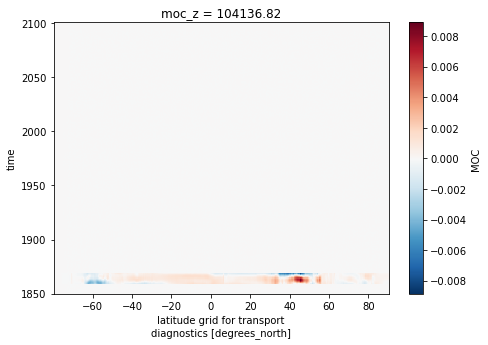

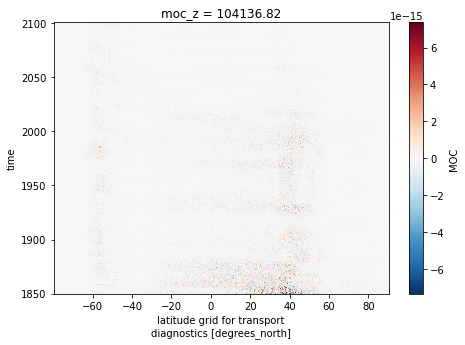

In [13]:
# Test for closure of variance budget:
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn+sig2_covar)
#sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2_resid.isel(transport_reg=0).plot(size=5)
sig2_covar.isel(transport_reg=0).plot(size=5)

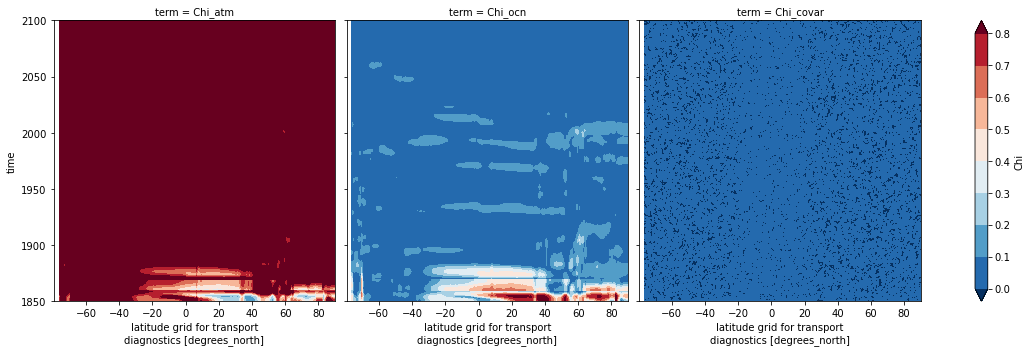

In [15]:
# Quick plot of Chi
chi = xr.concat([chi_atm,chi_ocn,chi_covar],dim=xr.DataArray(['Chi_atm','Chi_ocn','Chi_covar'],dims='term',name='term'))
levs = np.arange(0,9)*0.1
chi.isel(transport_reg=0).plot.contourf(col='term',size=5,levels=levs)

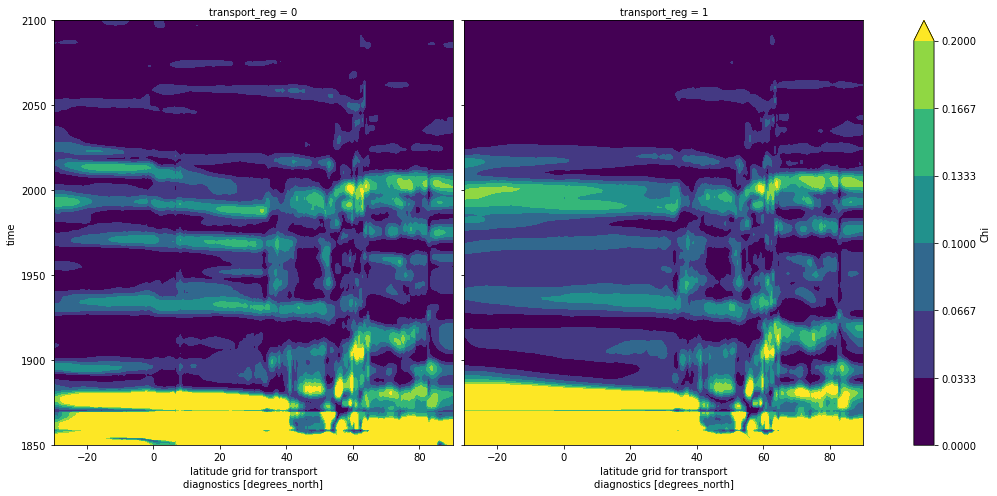

In [16]:
#fig, axes = plt.subplots(ncols=3)
chi_ocn.plot.contourf(col='transport_reg',vmin=0,vmax=0.2,size=7,xlim=[-30,90])
#chi_ocn_lpf.plot.contour(col='region',levels=[0.075],size=7,colors='r')

## Compute bootstrapped significance

In [15]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [16]:
%%time
iterations = 100
ens_size = 20
da_micros_r = xs.resample_iterations_idx(da_micros, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()

CPU times: user 6.99 s, sys: 3.38 s, total: 10.4 s
Wall time: 11 s


Now, resample again to generate 500 different 4-micro combinations:

In [17]:
da_micros_rr = xs.resample_iterations(da_micros_r, 500, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn, and chi_ocn:

In [18]:
%%time
sig2_atm_r = da_micros_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_micros_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_micros_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")

CPU times: user 15.1 s, sys: 6.62 s, total: 21.7 s
Wall time: 54.6 s


In [32]:
chi_ocn.data[:,1,0:92] = np.nan

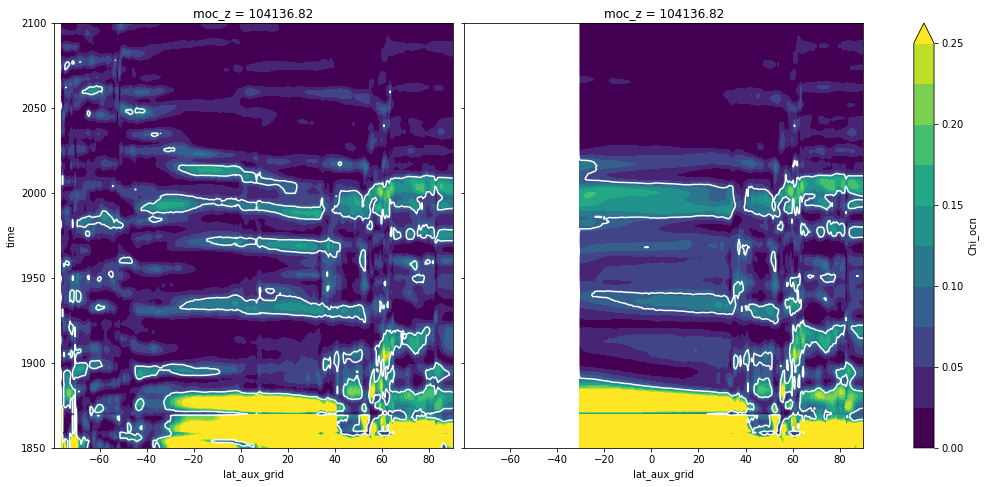

In [33]:
# Plot with bootstrapped significance
pval = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size
clevs = np.arange(0,11)*0.025

g = chi_ocn.plot.contourf(col='transport_reg',size=7,levels=clevs,cmap='viridis')
for i, ax in enumerate(g.axes.flat):
    pval.isel(transport_reg=i).plot.contour(ax=ax,levels=[0.05],colors=['white'])
    if (i>0): ax.set_ylabel('')

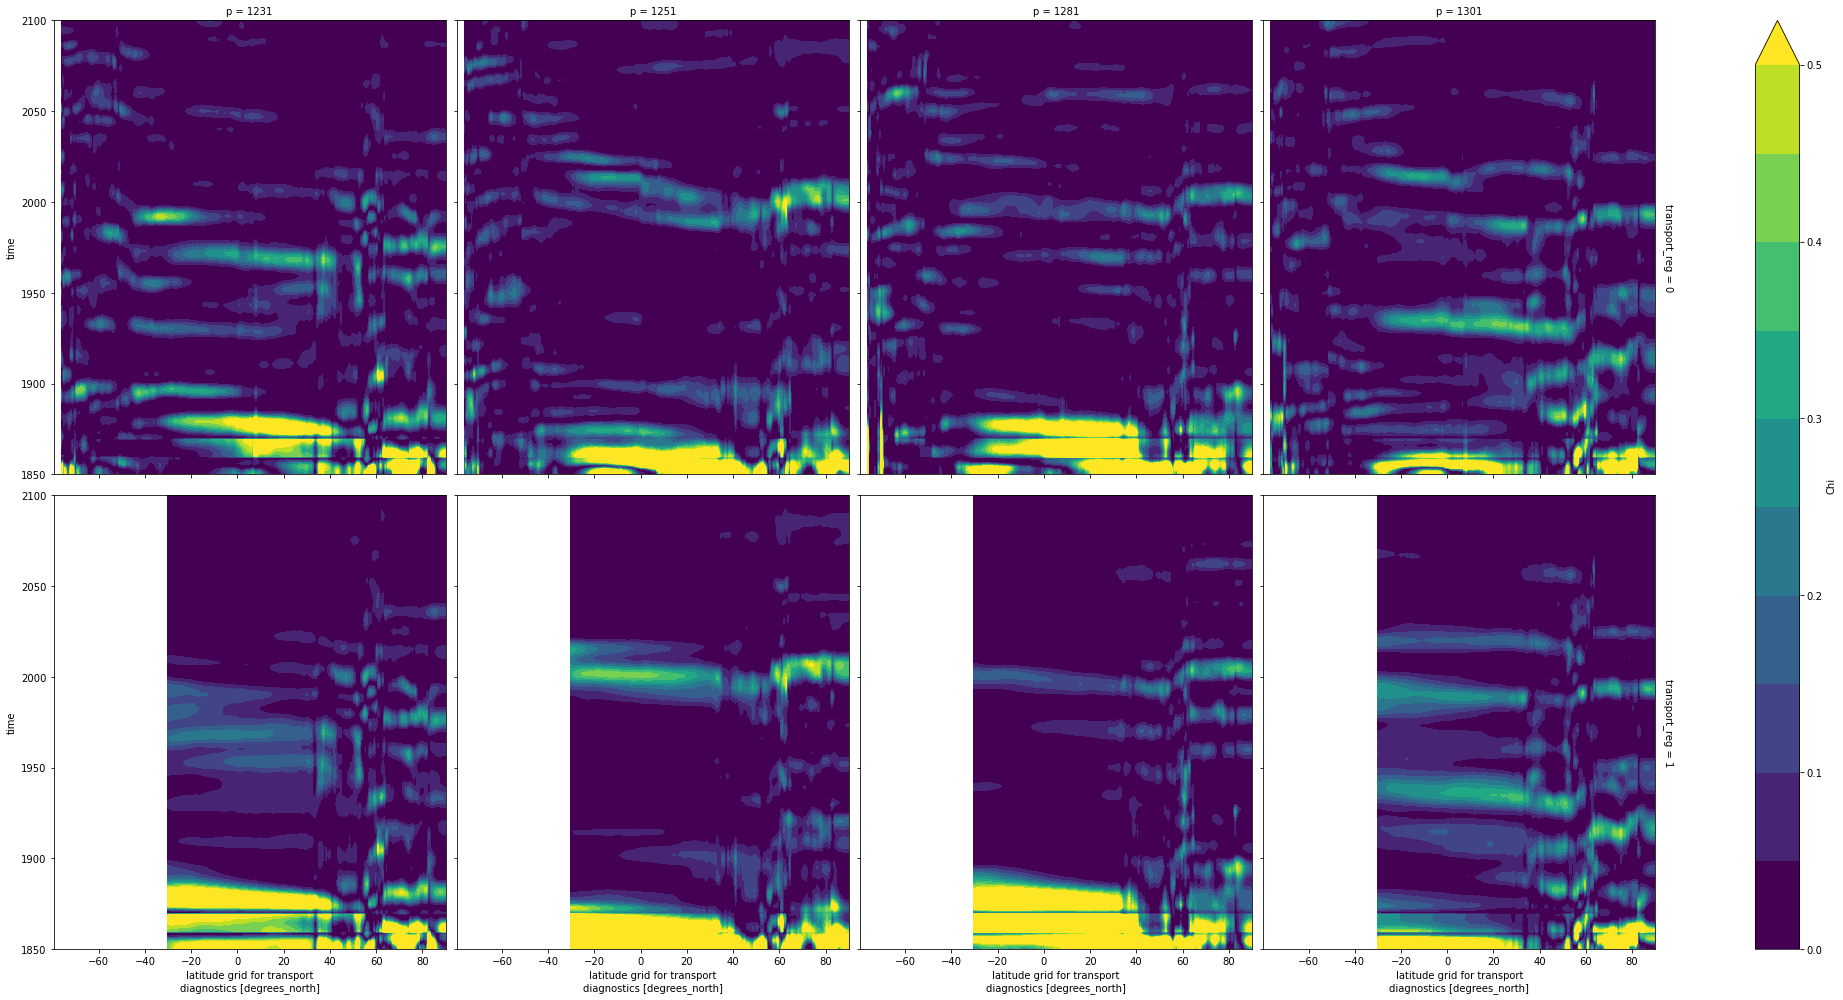

In [20]:
chi_ocn_p.data[:,:,1,0:92] = np.nan
# Plot decomposition of Chi_ocn by init year:
levs = np.arange(0,11)*0.05
chi_ocn_p.plot.contourf(col='p',row='transport_reg',size=7,levels=levs)

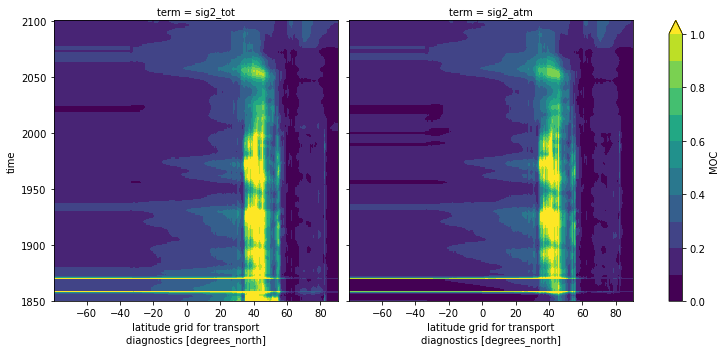

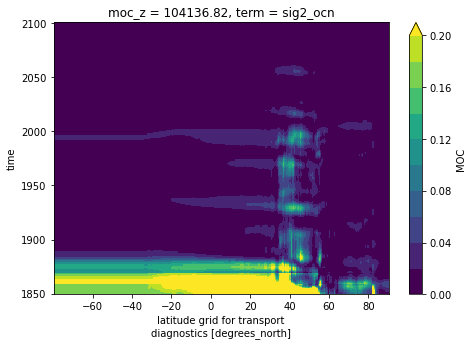

In [27]:
terms = xr.DataArray(['sig2_tot','sig2_atm','sig2_ocn','sig2_covar','sig2_residual'],dims='term',name='term')
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn+sig2_covar)
sig2 = xr.concat([sig2_tot,sig2_atm,sig2_ocn,sig2_covar,sig2_resid],dim=terms)

levs = np.arange(0,11)*0.1
sig2.isel(term=[0,1],transport_reg=1).plot(col='term',col_wrap=2,size=5,levels=levs)
levs = np.arange(0,11)*0.02
sig2.isel(term=2,transport_reg=1).plot(size=5,levels=levs)